Steamspy API

  * appid - Steam Application ID. If it's 999999, then data for this application is hidden on developer's request, sorry.
  * name - game's name
  * developer - comma separated list of the developers of the game
  * publisher - comma separated list of the publishers of the game
  * score_rank - score rank of the game based on user reviews
  * owners - owners of this application on Steam as a range.
  * average_forever - average playtime since March 2009. In minutes.
  * average_2weeks - average playtime in the last two weeks. In minutes.
  * median_forever - median playtime since March 2009. In minutes.
  * median_2weeks - median playtime in the last two weeks. In minutes.
  * ccu - peak CCU yesterday. (CCU : “concurrent users”)
  * price - current US price in cents.
  * initialprice - original US price in cents.
  * discount - current discount in percents.
  * tags - game's tags with votes in JSON array.
  * languages - list of supported languages.
  * genre - list of genres.

In [ ]:
import psycopg2
import pandas.io.sql as psql
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Error 생략
pd.options.mode.chained_assignment = None 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#한글 Font
import matplotlib as mpl
mpl.rc("font", family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

# 그래프 선명하게
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# DataBase에서 불러오기

In [ ]:
db = psycopg2.connect(host='john.db.elephantsql.com', dbname='mptqsere',user='mptqsere',password='XmjhDueuKG8ReGkOm7nGXunlDwevVI3L',port=5432)
df = psql.read_sql('SELECT * FROM steamspy_details inner join steamspy_otherdetails on steamspy_details.appid = steamspy_otherdetails.appid', db)
df = df.loc[:,~df.columns.duplicated()] #appid 중복 삭제

In [ ]:
df

,appid,name,developer,publisher,positive_review,negative_review,owners,average_playtime_from_2009,average_playtime_2weeks,median_playtime_from_2009,...,initial_price,current_price,discount_precent,ccu,language,genre,tags,release_year,steam_userscore,metascore
0,10,Counter-Strike,Valve,Valve,197400,5093,"10,000,000 .. 20,000,000",12960,368,229,...,999.0,199.0,80.0,12620,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 5420, 'FPS': 4823, 'Multiplayer': 3...",2000.0,97%,88%
1,20,Team Fortress Classic,Valve,Valve,5618,917,"5,000,000 .. 10,000,000",180,6,20,...,499.0,99.0,80.0,99,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 751, 'FPS': 310, 'Multiplayer': 261...",1999.0,85%,nan
2,30,Day of Defeat,Valve,Valve,5142,564,"5,000,000 .. 10,000,000",273,0,17,...,499.0,99.0,80.0,133,"English, French, German, Italian, Spanish - Spain",Action,"{'FPS': 789, 'World War II': 252, 'Multiplayer...",2003.0,90%,79%
3,40,Deathmatch Classic,Valve,Valve,1908,421,"5,000,000 .. 10,000,000",26,0,3,...,499.0,99.0,80.0,6,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 631, 'FPS': 142, 'Classic': 109, 'M...",2001.0,81%,nan
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,14051,702,"5,000,000 .. 10,000,000",256,440,145,...,499.0,99.0,80.0,157,"English, French, German, Korean",Action,"{'FPS': 889, 'Action': 330, 'Classic': 258, 'S...",1999.0,95%,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40919,1483110,Alien AI,GridSky Software AS,GridSky Software AS,5,3,"20,000 .. 50,000",0,0,0,...,999.0,499.0,50.0,0,English,"Adventure, Indie, Simulation","{'Aliens': 420, 'Artificial Intelligence': 414...",2021.0,nan,nan
40920,1483130,Puzlkind,"Michael Ferrier, Sarah Jane Lapp",IronZog LLC,14,4,"0 .. 20,000",0,0,0,...,0.0,0.0,0.0,0,English,"Casual, Free to Play, Massively Multiplayer","{'Puzzle': 233, 'Board Game': 226, 'Tabletop':...",2021.0,nan,nan
40921,1483140,The Trap,Technolomics,Technolomics,4,0,"0 .. 20,000",0,0,0,...,199.0,199.0,0.0,0,English,"Action, Adventure, Indie","{'Action-Adventure': 179, 'Puzzle': 174, 'Surv...",2020.0,nan,nan
40922,1483300,MazM: The Phantom of the Opera,Growing Seeds,"CFK Co., Ltd.",33,13,"0 .. 20,000",0,0,0,...,1499.0,749.0,50.0,1,"English, Russian, Japanese, Simplified Chinese...","Adventure, RPG, Simulation","{'RPG': 72, 'Adventure': 65, 'Visual Novel': 4...",2021.0,nan,nan


# 결측치 확인

- Nan, nan 이라는 Text가 포함되어있는 column이 있어, null값으로 변경해준다

In [ ]:
df2 = df.copy()
df2 = df2.replace({'NaN':np.nan, 'nan':np.nan})

In [ ]:
df2.isnull().sum()

appid                             0
name                              9
developer                       170
publisher                        85
positive_review                   0
negative_review                   0
owners                            0
average_playtime_from_2009        0
average_playtime_2weeks           0
median_playtime_from_2009         0
median_playtime_2weeks            0
initial_price                     9
current_price                    11
discount_precent                  9
ccu                               0
language                         43
genre                           230
tags                              0
release_year                   2452
steam_userscore               21666
metascore                     37244
dtype: int64

- `steam_userscore`, `metascore`의 결측치가 상당히 많음
- 게임 평론가 평가보단, 유저 평가가 개발자들에게 유용할 것으로 보이므로, `steam_userscore`의 결측치만 처리하기로 함
- `positive_review`, `negative_review`를 이용하여 계산한다 (계산식은 Steam DB 참고)


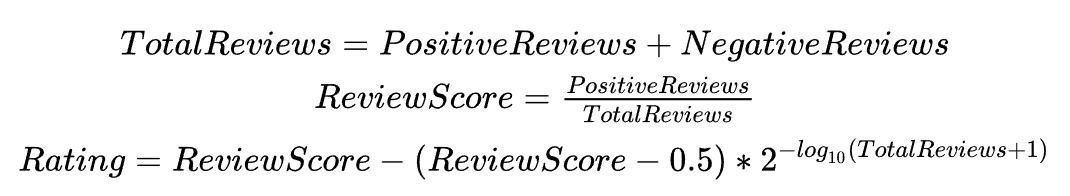

In [ ]:
null_index = df2[df2.steam_userscore.isnull()].index
for idx, row in df2.loc[null_index, :].iterrows():
    total_review = row['positive_review'] + row['negative_review']
    if total_review == 0: #Total review가 0인 경우는 계산할 수 없으므로, 추후 데이터셋에서 제거한다.
        pass
    else:
        review_score = row['positive_review'] / total_review
        rating = review_score-(review_score - 0.5)*2**(-math.log10(total_review + 1))
        rating = str(round(rating*100)) + '%'
        df2.loc[idx, 'steam_userscore'] = rating

In [ ]:
df2.steam_userscore.isnull().sum()

180

- steam score의 결측치 처리 이후에도 결측치로 남아있는 행은 drop 한다
- 게임 가격, 출시연도, 게임 장르와 언어 지원도 중요한 정보이므로, 해당 정보가 없는 경우는 drop 한다
- 개발사, 유통사 정보가 없는 경우는 소량의 데이터 이므로 drop 한다
- 메타스코어 column은 결측치가 너무 많으므로, drop한다

In [ ]:
df2 = df2.dropna(subset=['developer', 'publisher', 'initial_price', 'current_price', 'language', 'genre', 'release_year' ,'steam_userscore'], how='any')
df2 = df2.drop(columns='metascore')
df2 = df2.reset_index(drop=True)
df2

,appid,name,developer,publisher,positive_review,negative_review,owners,average_playtime_from_2009,average_playtime_2weeks,median_playtime_from_2009,median_playtime_2weeks,initial_price,current_price,discount_precent,ccu,language,genre,tags,release_year,steam_userscore
0,10,Counter-Strike,Valve,Valve,197400,5093,"10,000,000 .. 20,000,000",12960,368,229,522,999.0,199.0,80.0,12620,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 5420, 'FPS': 4823, 'Multiplayer': 3...",2000.0,97%
1,20,Team Fortress Classic,Valve,Valve,5618,917,"5,000,000 .. 10,000,000",180,6,20,6,499.0,99.0,80.0,99,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 751, 'FPS': 310, 'Multiplayer': 261...",1999.0,85%
2,30,Day of Defeat,Valve,Valve,5142,564,"5,000,000 .. 10,000,000",273,0,17,0,499.0,99.0,80.0,133,"English, French, German, Italian, Spanish - Spain",Action,"{'FPS': 789, 'World War II': 252, 'Multiplayer...",2003.0,90%
3,40,Deathmatch Classic,Valve,Valve,1908,421,"5,000,000 .. 10,000,000",26,0,3,0,499.0,99.0,80.0,6,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 631, 'FPS': 142, 'Classic': 109, 'M...",2001.0,81%
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,14051,702,"5,000,000 .. 10,000,000",256,440,145,440,499.0,99.0,80.0,157,"English, French, German, Korean",Action,"{'FPS': 889, 'Action': 330, 'Classic': 258, 'S...",1999.0,95%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38121,1483110,Alien AI,GridSky Software AS,GridSky Software AS,5,3,"20,000 .. 50,000",0,0,0,0,999.0,499.0,50.0,0,English,"Adventure, Indie, Simulation","{'Aliens': 420, 'Artificial Intelligence': 414...",2021.0,56%
38122,1483130,Puzlkind,"Michael Ferrier, Sarah Jane Lapp",IronZog LLC,14,4,"0 .. 20,000",0,0,0,0,0.0,0.0,0.0,0,English,"Casual, Free to Play, Massively Multiplayer","{'Puzzle': 233, 'Board Game': 226, 'Tabletop':...",2021.0,66%
38123,1483140,The Trap,Technolomics,Technolomics,4,0,"0 .. 20,000",0,0,0,0,199.0,199.0,0.0,0,English,"Action, Adventure, Indie","{'Action-Adventure': 179, 'Puzzle': 174, 'Surv...",2020.0,69%
38124,1483300,MazM: The Phantom of the Opera,Growing Seeds,"CFK Co., Ltd.",33,13,"0 .. 20,000",0,0,0,0,1499.0,749.0,50.0,1,"English, Russian, Japanese, Simplified Chinese...","Adventure, RPG, Simulation","{'RPG': 72, 'Adventure': 65, 'Visual Novel': 4...",2021.0,65%


In [ ]:
df2.isnull().sum()

appid                         0
name                          4
developer                     0
publisher                     0
positive_review               0
negative_review               0
owners                        0
average_playtime_from_2009    0
average_playtime_2weeks       0
median_playtime_from_2009     0
median_playtime_2weeks        0
initial_price                 0
current_price                 0
discount_precent              0
ccu                           0
language                      0
genre                         0
tags                          0
release_year                  0
steam_userscore               0
dtype: int64

# 특성 생성

In [ ]:
# genre와 tags에서 필요한 요소만 추출하기 위해 함수화
def genre_split(string):
    split_list = str(string).replace(' ','').split(',')
    return split_list

def tags_split(string):
    split_list = str(string).replace('{', '').replace(':','').replace(',', '').split("'")
    return split_list

In [ ]:
# 장르 중, 첫번째 요소를 대표 장르로 가정함
df2['FirstGenre'] = df2['genre'].map(lambda x: genre_split(x)[0])
# 해당 게임이 인디 게임인지?
df2['Indie'] = df2['genre'].map(lambda x: 1 if 'Indie' in genre_split(x) else 0)

# 해당 게임이 멀티플레이를 지원하는지?
df2['Multiplayer'] = df2['tags'].map(lambda x:1 if 'Multiplayer' in tags_split(x) else 0)
# 해당 게임이 코옵 플레이 (싱글플레이 미션을 함께 플레이)를 지원하는지?
df2['Co-op'] = df2['tags'].map(lambda x:1 if 'Co-op' in tags_split(x) or 'Co-Op' in tags_split(x) else 0)
# 해당 게임이 오픈월드 게임인지?
df2['OpenWorld'] = df2['tags'].map(lambda x:1 if 'Open World' in tags_split(x) else 0)
# 해당 게임이 호러 게임인지?
df2['Horror'] = df2['tags'].map(lambda x:1 if 'Horror' in tags_split(x) or 'Survival Horror' in tags_split(x) or 'Psychological Horror' in tags_split(x) else 0)
# 해당 게임이 잔인/폭력성이 있는지?
df2['Violent'] = df2['tags'].map(lambda x:1 if 'Gore' in tags_split(x) or 'Blood' in tags_split(x) or 'Violent' in tags_split(x) else 0)
# 해당 게임이 성적인 요소가 있는지?
df2['Sexual'] = df2['tags'].map(lambda x:1 if 'Sexual Content' in tags_split(x) else 0) #Nudity도 고려할 수 있지만, 단순히 알몸만 나오면 tag됨(다른 장르일 가능성 있음)

## FirstGenre 추가 처리

In [ ]:
df2['FirstGenre'].value_counts()

Action                  16279
Adventure                7871
Casual                   6253
Indie                    3585
Simulation                871
Strategy                  686
FreetoPlay                673
RPG                       574
Racing                    271
Animation&Modeling        219
Utilities                 199
Education                 135
Sports                    110
Design&Illustration       108
AudioProduction           104
VideoProduction            41
MassivelyMultiplayer       37
SoftwareTraining           27
Violent                    21
EarlyAccess                15
PhotoEditing               11
SexualContent              11
Accounting                  8
WebPublishing               5
GameDevelopment             5
Nudity                      4
Gore                        3
Name: FirstGenre, dtype: int64

- 'Action', 'Adventure', 'Casual','Strategy', 'Simulation', 'RPG', 'Sports', 'Racing' 장르만을 고려한다.
- 그 외 다른 장르들은 게임이 아니라고 판단한다

In [ ]:
genre_list = ['Action', 'Adventure', 'Casual','Strategy', 'Simulation', 'RPG', 'Sports', 'Racing']

# Firstgenre가 Indie 인 경우
df_temp = df2[(df2['FirstGenre'] == 'Indie')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'Indie':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

# Firstgenre가 FreetoPlay 인 경우
df_temp = df2[(df2['FirstGenre'] == 'FreetoPlay')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'FreetoPlay':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

# Firstgenre가 MassivelyMultiplayer 인 경우  
df_temp = df2[(df2['FirstGenre'] == 'MassivelyMultiplayer')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'MassivelyMultiplayer':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

# Firstgenre가 Violent 인 경우
df_temp = df2[(df2['FirstGenre'] == 'Violent')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'Violent':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

# Firstgenre가 EarlyAccess 인 경우
df_temp = df2[(df2['FirstGenre'] == 'EarlyAccess')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'EarlyAccess':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

# Firstgenre가 SexualContent 인 경우
df_temp = df2[(df2['FirstGenre'] == 'SexualContent')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'SexualContent':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

# Firstgenre가 Nudity 인 경우
df_temp = df2[(df2['FirstGenre'] == 'Nudity')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'Nudity':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

# Firstgenre가 Gore 인 경우
df_temp = df2[(df2['FirstGenre'] == 'Gore')]
for idx, row in df_temp.iterrows():
    tag = row['tags']
    tag_list = tags_split(tag)
    del tag_list[0]
    for element in tag_list :
            if element in genre_list: #첫번째 발견 요소만 if문 실행
                df2.loc[idx, 'FirstGenre'] = element

    if df2.loc[idx, 'FirstGenre'] == 'Gore':
        #print(idx, 'not exist correct genre')    
        df2.loc[idx, 'FirstGenre'] = None

In [ ]:
df2['FirstGenre'].value_counts()

Action                 16547
Adventure               8228
Casual                  6623
Simulation              1658
Strategy                1543
RPG                     1135
Racing                   353
Sports                   232
Animation&Modeling       219
Utilities                199
Education                135
Design&Illustration      108
AudioProduction          104
VideoProduction           41
SoftwareTraining          27
PhotoEditing              11
Accounting                 8
WebPublishing              5
GameDevelopment            5
Name: FirstGenre, dtype: int64

In [ ]:
df2['FirstGenre'].isnull().sum()

945

In [ ]:
df2 = df2[(df2['FirstGenre'] == 'Action') | (df2['FirstGenre'] == 'Adventure') | (df2['FirstGenre'] == 'Casual') | 
    (df2['FirstGenre'] == 'Simulation') |  (df2['FirstGenre'] == 'Strategy') | (df2['FirstGenre'] == 'RPG') | 
    (df2['FirstGenre'] == 'Racing') | (df2['FirstGenre'] == 'Sports')]

df2 = df2.reset_index(drop=True)    
df2

,appid,name,developer,publisher,positive_review,negative_review,owners,average_playtime_from_2009,average_playtime_2weeks,median_playtime_from_2009,...,release_year,steam_userscore,FirstGenre,Indie,Multiplayer,Co-op,OpenWorld,Horror,Violent,Sexual
0,10,Counter-Strike,Valve,Valve,197400,5093,"10,000,000 .. 20,000,000",12960,368,229,...,2000.0,97%,Action,0,1,0,0,0,0,0
1,20,Team Fortress Classic,Valve,Valve,5618,917,"5,000,000 .. 10,000,000",180,6,20,...,1999.0,85%,Action,0,1,1,0,0,1,0
2,30,Day of Defeat,Valve,Valve,5142,564,"5,000,000 .. 10,000,000",273,0,17,...,2003.0,90%,Action,0,1,1,0,0,0,0
3,40,Deathmatch Classic,Valve,Valve,1908,421,"5,000,000 .. 10,000,000",26,0,3,...,2001.0,81%,Action,0,1,1,0,0,1,0
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,14051,702,"5,000,000 .. 10,000,000",256,440,145,...,1999.0,95%,Action,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36314,1483110,Alien AI,GridSky Software AS,GridSky Software AS,5,3,"20,000 .. 50,000",0,0,0,...,2021.0,56%,Adventure,1,0,0,0,1,0,0
36315,1483130,Puzlkind,"Michael Ferrier, Sarah Jane Lapp",IronZog LLC,14,4,"0 .. 20,000",0,0,0,...,2021.0,66%,Casual,0,1,0,0,0,0,0
36316,1483140,The Trap,Technolomics,Technolomics,4,0,"0 .. 20,000",0,0,0,...,2020.0,69%,Action,1,0,0,0,1,0,0
36317,1483300,MazM: The Phantom of the Opera,Growing Seeds,"CFK Co., Ltd.",33,13,"0 .. 20,000",0,0,0,...,2021.0,65%,Adventure,0,0,0,0,0,0,0


In [ ]:
# 해당 게임의 지원 언어 수
df2['Num_Language'] = df2['language'].map(lambda x: len(x.replace(' ','').split(',')))
# 해당 게임이 한국어를 지원하는지?
df2['Korean'] = df2['language'].map(lambda x: 1 if 'Korean' in x.replace(' ','').split(',') else 0)

In [ ]:
# Cent 단위로 되어있는 게임 가격을 달러 단위로 변환
df2['initial_price'] = df2['initial_price']*0.01
df2['current_price'] = df2['current_price']*0.01

# 출시이후 가격 할인을 했는지?
df2['discount'] = df2['current_price'] != df2['initial_price']
df2['discount'] = df2['discount'].astype(int)

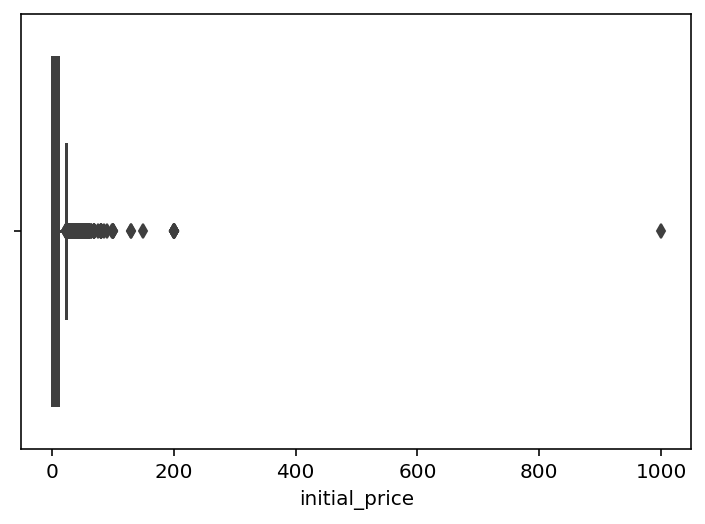

In [ ]:
sns.boxplot(x = 'initial_price', data=df2)
plt.show()

- 출시가격에 대한 이상치가 확인되어, 제거한다

In [ ]:
df2 = df2.drop(index=df2[df2['initial_price'] == 999.0].index)

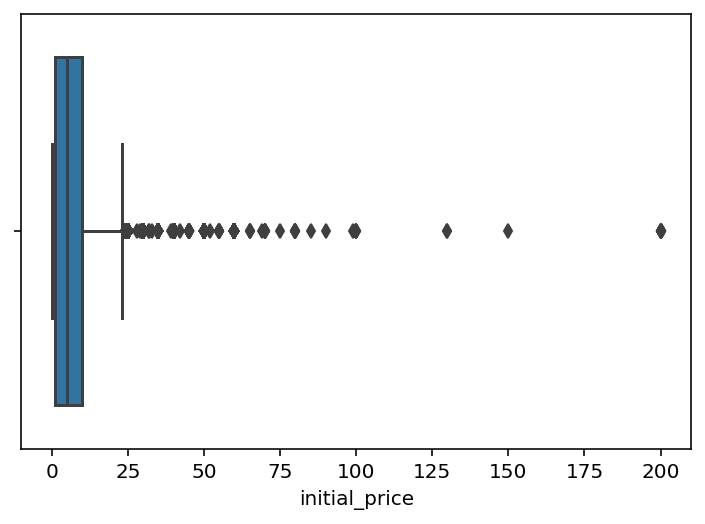

In [ ]:
sns.boxplot(x = 'initial_price', data=df2)
plt.show()

In [ ]:
pd.qcut(df2[df2.initial_price > 0]['initial_price'], 4).value_counts()

(0.899, 2.99]      8296
(5.99, 11.99]      7742
(11.99, 199.99]    7138
(2.99, 5.99]       6819
Name: initial_price, dtype: int64

In [ ]:
# 출시 가격에 대한 그룹화
df2['price_group'] = 'Free' # 무료게임
df2.loc[df2[(df2['initial_price'] > 0.899)&(df2['initial_price'] <= 2.99)].index, 'price_group'] = '0.899 .. 2.99'
df2.loc[df2[(df2['initial_price'] > 2.99)&(df2['initial_price'] <= 5.99)].index, 'price_group'] = '2.99 .. 5.99'
df2.loc[df2[(df2['initial_price'] > 5.99)&(df2['initial_price'] <= 11.99)].index, 'price_group'] = '5.99 .. 11.99'
df2.loc[df2[(df2['initial_price'] > 11.99)&(df2['initial_price'] <= 199.99)].index, 'price_group'] = '11.99 .. 199.99'
df2['price_group'].value_counts()

0.899 .. 2.99      8296
5.99 .. 11.99      7742
11.99 .. 199.99    7138
2.99 .. 5.99       6819
Free               6323
Name: price_group, dtype: int64

In [ ]:
#playtime 단위를 '분'에서 '시'로 변경
df2['average_playtime_from_2009'] = round(df2['average_playtime_from_2009'] / 60)

#release_year data type 변경
df2['release_year'] = df2['release_year'].astype(float)
df2['release_year'] = df2['release_year'].astype(int)

In [ ]:
df2.owners.value_counts()

0 .. 20,000                   22622
20,000 .. 50,000               5343
50,000 .. 100,000              2838
100,000 .. 200,000             2023
200,000 .. 500,000             1816
500,000 .. 1,000,000            800
1,000,000 .. 2,000,000          447
2,000,000 .. 5,000,000          295
5,000,000 .. 10,000,000          80
10,000,000 .. 20,000,000         32
20,000,000 .. 50,000,000         17
50,000,000 .. 100,000,000         4
100,000,000 .. 200,000,000        1
Name: owners, dtype: int64

In [ ]:
# 10만, 100만, 1000만.. 단위로 변경
# 100,000,000 .. 200,000,000 는 데이터가 하나이므로, 마지막 그룹에 포함시킴
df2.loc[df2[(df2['owners'] == '0 .. 20,000') | (df2['owners'] == '20,000 .. 50,000') | (df2['owners'] == '50,000 .. 100,000')].index, 'owners']= '0-100,000'
df2.loc[df2[(df2.owners == '100,000 .. 200,000') | (df2.owners == '200,000 .. 500,000') | (df2.owners == '500,000 .. 1,000,000')].index, 'owners'] = '100,000-1,000,000'
df2.loc[df2[(df2.owners == '1,000,000 .. 2,000,000') | (df2.owners == '2,000,000 .. 5,000,000') | (df2.owners == '5,000,000 .. 10,000,000')].index, 'owners'] = '1,000,000-10,000,000'
df2.loc[df2[(df2.owners == '10,000,000 .. 20,000,000') | (df2.owners == '20,000,000 .. 50,000,000') | (df2.owners == '50,000,000 .. 100,000,000') | (df2.owners == '100,000,000 .. 200,000,000')].index, 'owners'] = '10,000,000-100,000,000'
df2.owners.value_counts()

0-100,000                 30803
100,000-1,000,000          4639
1,000,000-10,000,000        822
10,000,000-100,000,000       54
Name: owners, dtype: int64

- 구간별 평가 문구
    - 80 - 100% : 매우 긍정적 (Very Positive)
    - 70 - 79% : 대체로 긍정적 (Mostly Positive)
    - 40 - 69% : 복합적 (Mixed)
    - 20 - 39% : 대체로 부정적 (Mostly Negative)
    - 0 - 19% : 매우 부정적 (Very Negative)
- 출처 : https://minimap.net/magazine/steam-overwhelmingly-positive

In [ ]:
# User Score group 
df2.steam_userscore = df2.steam_userscore.str.replace('%', '').astype(int)
df2['steam_userscore_group'] = 0
df2.loc[df2[df2['steam_userscore'] < 20].index, 'steam_userscore_group'] = 'Very Negative'
df2.loc[df2[(df2['steam_userscore'] >= 20)&(df2['steam_userscore'] < 40)].index, 'steam_userscore_group'] = 'Mostly Negative'
df2.loc[df2[(df2['steam_userscore'] >= 40)&(df2['steam_userscore'] < 70)].index, 'steam_userscore_group'] = 'Mixed'
df2.loc[df2[(df2['steam_userscore'] >= 70)&(df2['steam_userscore'] < 80)].index, 'steam_userscore_group'] = 'Mostly Positive'
df2.loc[df2[df2['steam_userscore'] >= 80].index, 'steam_userscore_group'] = 'Very Positive'

In [ ]:
df2.steam_userscore_group.value_counts()

Mixed              18068
Very Positive       9122
Mostly Positive     7075
Mostly Negative     1992
Very Negative         61
Name: steam_userscore_group, dtype: int64

In [ ]:
df2 = df2.drop(columns=['positive_review', 'negative_review', 'average_playtime_2weeks', 'median_playtime_from_2009', 'median_playtime_2weeks', 'language', 'genre', 'tags', 'steam_userscore'])

In [ ]:
df2.head(3)

,appid,name,developer,publisher,owners,average_playtime_from_2009,initial_price,current_price,discount_precent,ccu,...,Co-op,OpenWorld,Horror,Violent,Sexual,Num_Language,Korean,discount,price_group,steam_userscore_group
0,10,Counter-Strike,Valve,Valve,"10,000,000-100,000,000",216.0,9.99,1.99,80.0,12620,...,0,0,0,0,0,8,1,1,5.99 .. 11.99,Very Positive
1,20,Team Fortress Classic,Valve,Valve,"1,000,000-10,000,000",3.0,4.99,0.99,80.0,99,...,1,0,0,1,0,9,1,1,2.99 .. 5.99,Very Positive
2,30,Day of Defeat,Valve,Valve,"1,000,000-10,000,000",5.0,4.99,0.99,80.0,133,...,1,0,0,0,0,5,0,1,2.99 .. 5.99,Very Positive


In [ ]:
df2.columns

Index(['appid', 'name', 'developer', 'publisher', 'owners',
       'average_playtime_from_2009', 'initial_price', 'current_price',
       'discount_precent', 'ccu', 'release_year', 'FirstGenre', 'Indie',
       'Multiplayer', 'Co-op', 'OpenWorld', 'Horror', 'Violent', 'Sexual',
       'Num_Language', 'Korean', 'discount', 'price_group',
       'steam_userscore_group'],
      dtype='object')

In [ ]:
df2.to_csv('1_3_3_steamspy_dataset.csv')

# DB 저장

In [ ]:
conn = psycopg2.connect(
    host = 'john.db.elephantsql.com',
    password = 'XmjhDueuKG8ReGkOm7nGXunlDwevVI3L',
    user = 'mptqsere',
    database = 'mptqsere'
    )
print(conn)
cur = conn.cursor()
# Table Create
# steamspy_dataset
def Create_table_steamspy_dataset () :
    cur.execute("DROP TABLE IF EXISTS steamspy_dataset;")
    cur.execute("""
            CREATE TABLE steamspy_dataset (
            "appid" INTEGER PRIMARY KEY,
            "name" TEXT,
            "developer" TEXT,
            "publisher" TEXT,
            "owners" TEXT,
            "average_playtime_from_2009" INTEGER,     
            "initial_price" FLOAT,
            "current_price" FLOAT,
            "discount_precent" FLOAT,
            "ccu" INTEGER,
            "release_year" INTEGER,
            "FirstGenre" TEXT,
            "Indie" INTEGER,
            "Multiplayer" INTEGER, 
            "Co-op" INTEGER, 
            "OpenWorld" INTEGER, 
            "Horror" INTEGER, 
            "Violent" INTEGER, 
            "Sexual" INTEGER,
            "Num_Language" INTEGER, 
            "Korean" INTEGER, 
            "discount" INTEGER, 
            "price_group" TEXT,
            "steam_userscore_group" TEXT,
            FOREIGN KEY(appid) REFERENCES app_list(Id)
            );
            """)
    return "Done Create steamspy_dataset Table."
Create_table_steamspy_dataset()

<connection object at 0x7f346d8c4a50; dsn: 'user=mptqsere password=xxx dbname=mptqsere host=john.db.elephantsql.com', closed: 0>


'Done Create steamspy_dataset Table.'

In [ ]:
# Insert Data into steamspy_details Table
for idx, row in df2.iterrows() :
    cur.execute(
        "INSERT INTO steamspy_dataset VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",
        (row['appid'], str(row['name']), str(row['developer']), str(row['publisher']), str(row['owners']), row['average_playtime_from_2009'],
        row['initial_price'], row['current_price'], row['discount_precent'], row['ccu'], row['release_year'], str(row['FirstGenre']),
        row['Indie'], row['Multiplayer'], row['Co-op'], row['OpenWorld'], row['Horror'], row['Violent'], row['Sexual'],
        row['Num_Language'], row['Korean'], row['discount'], str(row['price_group']), str(row['steam_userscore_group']))
    )
    conn.commit()
    print('Insert Data: ', idx + 1)
    print('appid :', row['appid'])   